In [134]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.lines as mlines

In [39]:
# Configurar a seed do TensorFlow
tf.random.set_seed(42)

# Configurar a seed do NumPy
np.random.seed(42)

# Configurar a seed do Keras (caso precise especificar a n√≠vel do Keras)
keras.backend.clear_session()

# Definir o n√∫mero de threads
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Para evitar log excessivo de TensorFlow
os.environ['OMP_NUM_THREADS'] = '1'  # Para limitar o n√∫mero de threads

# Definir a seed global para a opera√ß√£o de GPU
tf.config.experimental.enable_op_determinism()

In [40]:
# Carregar o dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalizar os dados (valores entre 0 e 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Verificar as dimens√µes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# Criar mapeamento bin√°rio (1 = vestu√°rio, 0 = cal√ßado/malas)
BINARY_MAP = {
    0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 6: 1,  # Vestu√°rio -> 1
    5: 0, 7: 0, 8: 0, 9: 0   # Cal√ßado/Malas -> 0
}

# Aplicar o mapeamento ANTES de transformar em one-hot encoding
y_train_bin = np.vectorize(BINARY_MAP.get)(y_train)
y_test_bin = np.vectorize(BINARY_MAP.get)(y_test)

# One-hot encoding para multiclasse
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Definir tamanho da imagem
IMG_HEIGHT, IMG_WIDTH = 28, 28


x_train shape: (60000, 28, 28), y_train shape: (60000,)


In [41]:
# Definir constantes
N_CLASSES = 10  # Fashion MNIST tem 10 categorias

# Criar o modelo com a mesma arquitetura usada no treino
model1 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH)),  # Input das imagens 28x28
    layers.Flatten(),  # Transformar imagem 28x28 num vetor 1D
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(N_CLASSES, activation='softmax')  # 10 classes
])

# Compilar o modelo (os pesos carregados n√£o alteram a compila√ß√£o)
model1.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Carregar os pesos do modelo treinado
model1.load_weights("tmp/best_model.weights.h5")

c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 488us/step


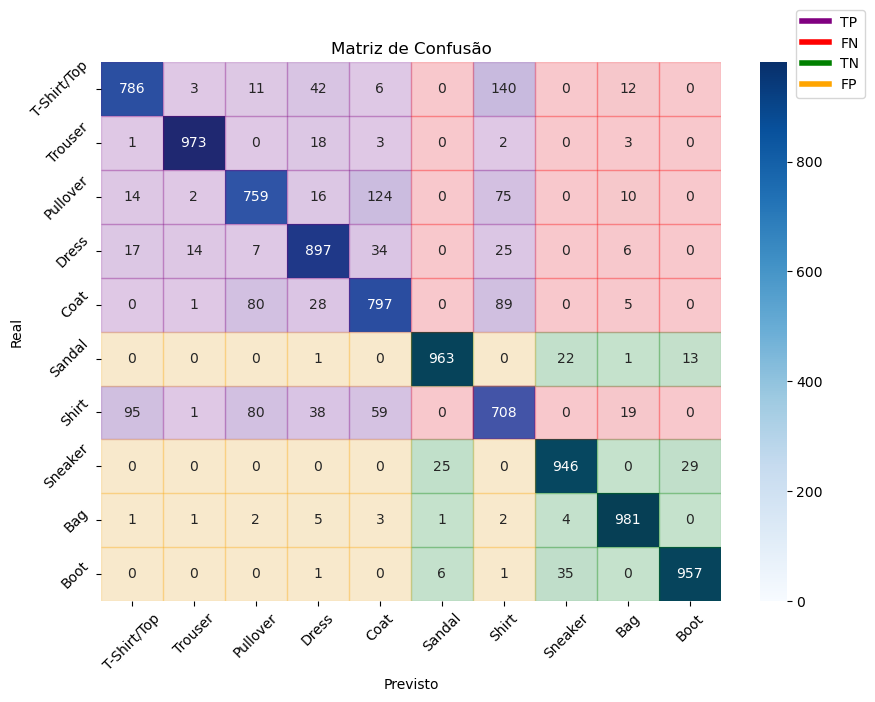

In [151]:
# N√£o foi o chatgpt que fez isso

# Predi√ß√µes e matriz de confus√£o
y_pred = model1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Sele√ß√£o da classe com maior probabilidade
y_true_classes = y_test  # y_test j√° cont√©m as classes reais

# Gerar a matriz de confus√£o
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Criar a figura com o tamanho desejado
plt.figure(figsize=(10, 7))

# Definir as etiquetas das classes
LABELS = ["T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat", 
          "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

# Criar a matriz de confus√£o utilizando seaborn
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)

# Adicionar cores para as diferentes regi√µes da matriz de confus√£o

# Regi√µes superiores (linhas 0-4 e colunas 0-4)
for i in range(5):
    for j in range(5):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='purple', lw=1, alpha=0.2))

# Regi√£o extra (linha 6)
for i in range(5):
    ax.add_patch(plt.Rectangle((6, i), 1, 1, fill=True, color='purple', lw=1, alpha=0.2))

# Regi√£o extra (coluna 6)
for j in range(5):
    ax.add_patch(plt.Rectangle((j, 6), 1, 1, fill=True, color='purple', lw=1, alpha=0.2))

# Regi√£o especial (interse√ß√£o da linha 6 e coluna 6)
ax.add_patch(plt.Rectangle((6, 6), 1, 1, fill=True, color='purple', lw=1.1, alpha=0.3))

# Linhas adicionais (linhas 0-4 e colunas 7-10)
for i in range(5):
    for j in range(7, 10):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red', lw=1, alpha=0.2))

# Regi√£o extra (linha 5)
for i in range(5):
    ax.add_patch(plt.Rectangle((5, i), 1, 1, fill=True, color='red', lw=1, alpha=0.2))

# Regi√£o extra (interse√ß√£o das colunas 7-10 e linha 6)
ax.add_patch(plt.Rectangle((5, 6), 1, 1, fill=True, color='red', lw=1, alpha=0.2))

for j in range(7, 10):
    ax.add_patch(plt.Rectangle((j, 6), 1, 1, fill=True, color='red', lw=1, alpha=0.2))

# Regi√£o intermedi√°ria (linhas 7-10 e colunas 7-10)
for i in range(7, 10):
    for j in range(7, 10):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=1, alpha=0.2))

# Regi√£o intermedi√°ria (interse√ß√µes de linha 5 e linha 6)
for j in range(7, 10):
    ax.add_patch(plt.Rectangle((j, 5), 1, 1, fill=True, color='green', lw=1, alpha=0.2))

for i in range(7, 10):
    ax.add_patch(plt.Rectangle((5, i), 1, 1, fill=True, color='green', lw=1, alpha=0.2))

# Regi√£o central (interse√ß√£o das linhas 5 e 6)
ax.add_patch(plt.Rectangle((5, 5), 1, 1, fill=True, color='green', lw=1, alpha=0.2))

# Regi√£o final (linhas 7-10 e colunas 0-4)
for i in range(7, 10):
    for j in range(5):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='orange', lw=1, alpha=0.2))

# Regi√£o final (linha 5)
for j in range(5):
    ax.add_patch(plt.Rectangle((j, 5), 1, 1, fill=True, color='orange', lw=1, alpha=0.2))

# Regi√£o final (linha 6)
for i in range(7, 10):
    ax.add_patch(plt.Rectangle((6, i), 1, 1, fill=True, color='orange', lw=1, alpha=0.2))

# Regi√£o final (interse√ß√£o da linha 6 e 5)
ax.add_patch(plt.Rectangle((6, 5), 1, 1, fill=True, color='orange', lw=1, alpha=0.2))

# Adicionar r√≥tulos e t√≠tulo ao gr√°fico
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o')

# Rotacionar as labels dos eixos x e y para melhor visualiza√ß√£o
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Adicionar a legenda para as cores
purple_patch = mlines.Line2D([], [], color='purple', lw=4, label='TP')
red_patch = mlines.Line2D([], [], color='red', lw=4, label='FN')
orange_patch = mlines.Line2D([], [], color='orange', lw=4, label='FP')
green_patch = mlines.Line2D([], [], color='green', lw=4, label='TN')

plt.legend(handles=[purple_patch, red_patch, green_patch, orange_patch], loc='best', bbox_to_anchor=(1.11, 1.11))

# Exibir o gr√°fico
plt.show()


In [42]:
# Definir constantes
N_CLASSES = 2

# Criar o modelo
model2 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH)),
    layers.Flatten(),  # Transformar imagem 28x28 num vetor 1D
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(N_CLASSES - 1),  # Camada de sa√≠da com a classe da label
    layers.Activation('sigmoid'),
])

# Compilar o modelo
model2.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Carregar os pesos do modelo treinado
model2.load_weights("tmp/best_model_part2.weights.h5")

In [43]:
# Obter previs√µes do modelo multiclasse
y_pred1 = np.argmax(model1.predict(x_test), axis=1)  # Converter de one-hot para classes
# Aplicar o mapeamento bin√°rio √†s previs√µes do modelo multiclasse
y_pred1_bin = np.vectorize(BINARY_MAP.get)(y_pred1)
# Previs√µes do modelo bin√°rio (limiar de 0.5)
y_pred2 = (model2.predict(x_test) > 0.5).astype(int).flatten()


313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 544us/step
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 500us/step


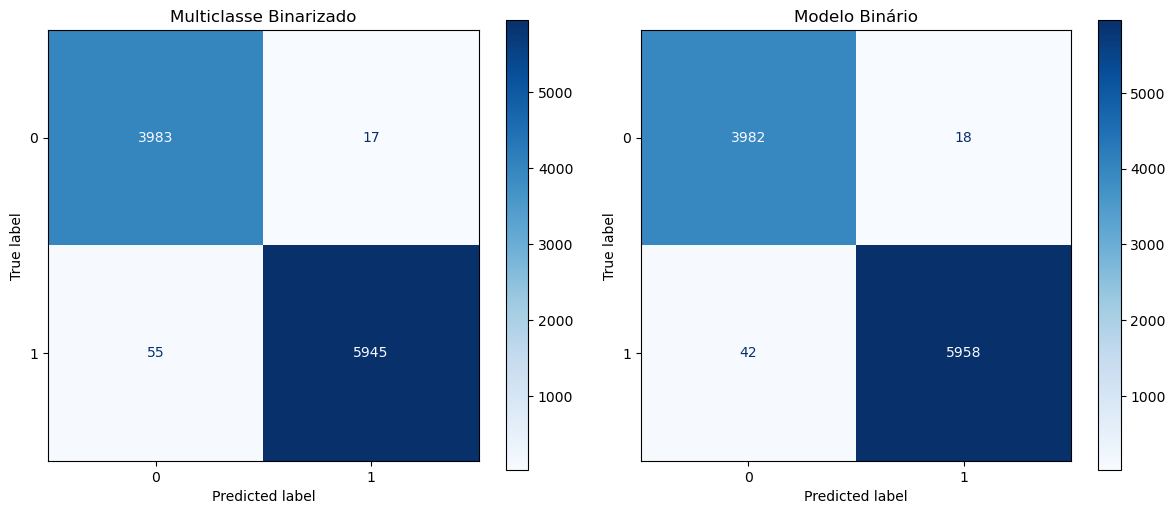

In [ ]:
def plot_confusion_matrices(y_true1, y_pred1, title1, y_true2, y_pred2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Matriz de confus√£o do primeiro modelo
    cm1 = confusion_matrix(y_true1, y_pred1)
    disp1 = ConfusionMatrixDisplay(cm1, display_labels=[0, 1])
    disp1.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(title1)

    # Matriz de confus√£o do segundo modelo
    cm2 = confusion_matrix(y_true2, y_pred2)
    disp2 = ConfusionMatrixDisplay(cm2, display_labels=[0, 1])
    disp2.plot(cmap='Blues', ax=axes[1])
    axes[1].set_title(title2)

    plt.tight_layout()
    plt.show()

# Chamar a fun√ß√£o para mostrar as matrizes lado a lado
plot_confusion_matrices(
    y_test_bin, y_pred1_bin, "Multiclasse Binarizado",
    y_test_bin, y_pred2, "Modelo Bin√°rio"
)

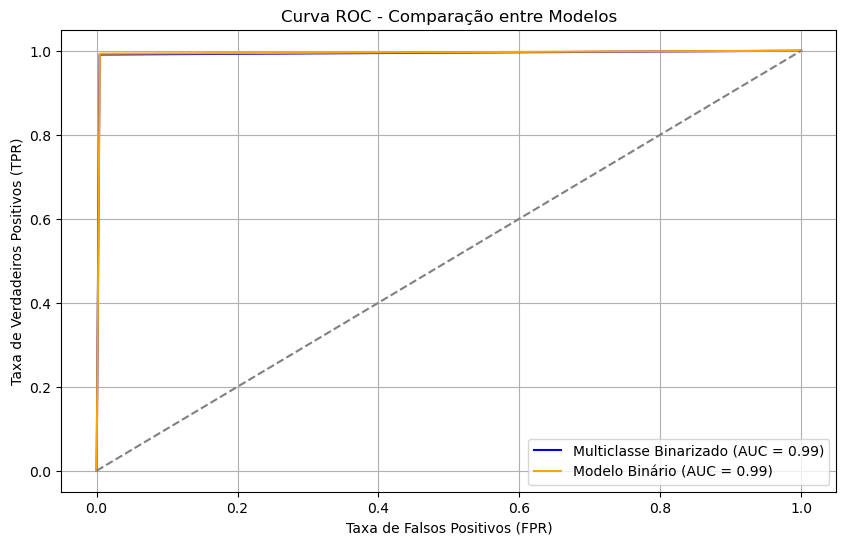

In [45]:
def plot_roc_curve(y_true1, y_pred1, label1, y_true2, y_pred2, label2):
    # Calcular as curvas ROC
    fpr1, tpr1, _ = roc_curve(y_true1, y_pred1)
    fpr2, tpr2, _ = roc_curve(y_true2, y_pred2)

    # Calcular a AUC (√Årea sob a curva)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)

    # Plotar as curvas ROC
    plt.figure(figsize=(10, 6))
    plt.plot(fpr1, tpr1, color='blue', label=f'{label1} (AUC = {auc1:.2f})')
    plt.plot(fpr2, tpr2, color='orange', label=f'{label2} (AUC = {auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (chance aleat√≥ria)
    
    # Adicionar t√≠tulo e r√≥tulos
    plt.title('Curva ROC - Compara√ß√£o entre Modelos')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Chamar a fun√ß√£o para plotar as duas curvas ROC
plot_roc_curve(y_test_bin, y_pred1_bin, 'Multiclasse Binarizado', 
               y_test_bin, y_pred2, 'Modelo Bin√°rio')


In [51]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    
    print("-" * 30)
    print(f"üìä {model_name}")
    print(f"üîπ Acur√°cia: {acc:.4f}")
    print(f"üîπ Precis√£o: {prec:.4f}")
    print(f"üîπ Recall: {rec:.4f}")
    print(f"üîπ f1-score: {f_score:.4f}")

# Avalia√ß√£o dos dois modelos
evaluate_model(y_test_bin, y_pred1_bin, "Modelo Multiclasse Binarizado")
evaluate_model(y_test_bin, y_pred2, "Modelo Bin√°rio")
print("-" * 30)


------------------------------
üìä Modelo Multiclasse Binarizado
üîπ Acur√°cia: 0.9928
üîπ Precis√£o: 0.9971
üîπ Recall: 0.9908
üîπ f1-score: 0.9940
------------------------------
üìä Modelo Bin√°rio
üîπ Acur√°cia: 0.9940
üîπ Precis√£o: 0.9970
üîπ Recall: 0.9930
üîπ f1-score: 0.9950
------------------------------


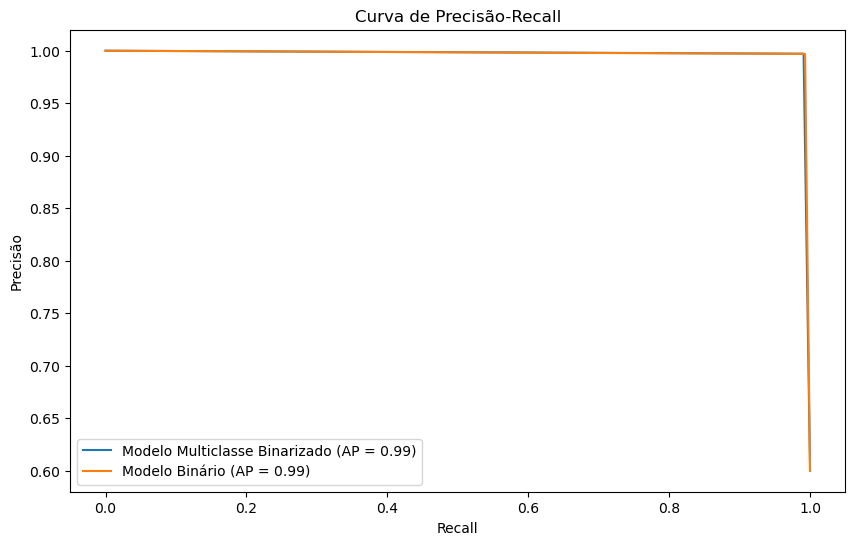

In [56]:
def plot_precision_recall_curve(y_true, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    plt.plot(recall, precision, label=f'{model_name} (AP = {average_precision:.2f})')

# Plotar a Curva de Precis√£o-Recall para ambos os modelos
plt.figure(figsize=(10, 6))
plot_precision_recall_curve(y_test_bin, y_pred1_bin, 'Modelo Multiclasse Binarizado')
plot_precision_recall_curve(y_test_bin, y_pred2, 'Modelo Bin√°rio')
plt.xlabel('Recall')
plt.ylabel('Precis√£o')
plt.title('Curva de Precis√£o-Recall')
plt.legend(loc='lower left')
plt.show()